# Tutorial on the LIDA Python API

Lida offers a manager class that exposes core functionality of the LIDA system. This tutorial will show you how to use the manager class to create visualizations based on a dataset

In [1]:
import json 
from lida import TextGenerationConfig , text_generator
from lida.modules import Manager
from lida.utils import plot_raster 

## Summarize Data, Generate Goals

In [2]:
lida = Manager(text_gen = text_generator("openai")) 
textgen_config = TextGenerationConfig(n=1, temperature=0.5, use_cache=True, max_tokens=1000)

summary = lida.summarize("experimental/data/cars.csv", enrich=False, textgen_config=textgen_config) 
goals = lida.generate_goals(summary, n=2, textgen_config=textgen_config)
print(goals)

/home/victordibia/projects/projectlida/lidarepo/lida/modules/summarizer.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[column], errors='raise')
/home/victordibia/projects/projectlida/lidarepo/lida/modules/summarizer.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[column], errors='raise')


[Goal(index=0, question='What is the relationship between Miles_per_Gallon and Weight_in_lbs?', visualization='scatter plot of Miles_per_Gallon vs Weight_in_lbs', rationale='This visualization can help us understand if there is any correlation between the weight of a car and its fuel efficiency.'), Goal(index=1, question='What is the distribution of Cylinders?', visualization='bar chart of the count of Cylinders', rationale='This visualization can help us understand the most common number of cylinders in the cars in the dataset.')]


## Generate Visualizations

Code for generated chart: import matplotlib.pyplot as plt
import pandas as pd

def plot(data: pd.DataFrame):
    # scatter plot of Miles_per_Gallon vs Weight_in_lbs
    plt.scatter(data['Weight_in_lbs'], data['Miles_per_Gallon'], c=data['Cylinders'], cmap='viridis')
    plt.xlabel('Weight_in_lbs')
    plt.ylabel('Miles_per_Gallon')
    plt.title('What is the relationship between Miles_per_Gallon and Weight_in_lbs?', wrap=True)
    plt.colorbar(label='Cylinders')
    return plt;

chart = plot(data)


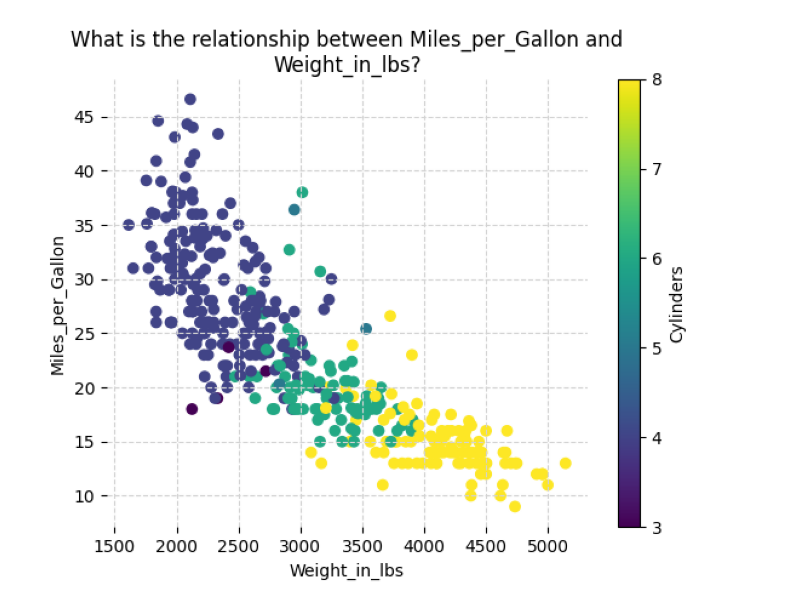

In [3]:
i = 0
library = "matplotlib"
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True, max_tokens=2000)
vis_specs = lida.generate_viz(summary=summary, goal=goals[i], textgen_config=textgen_config, library=library) 
charts = lida.execute_viz(code_specs=vis_specs, data=lida.data, summary=summary, library=library )
print("Code for generated chart:", charts[0].code)

# plot raster image of chart
plot_raster(charts[0].raster) 

In [4]:
vis_specs

["import matplotlib.pyplot as plt\nimport pandas as pd\n\ndef plot(data: pd.DataFrame):\n    # scatter plot of Miles_per_Gallon vs Weight_in_lbs\n    plt.scatter(data['Weight_in_lbs'], data['Miles_per_Gallon'], c=data['Cylinders'], cmap='viridis')\n    plt.xlabel('Weight_in_lbs')\n    plt.ylabel('Miles_per_Gallon')\n    plt.title('What is the relationship between Miles_per_Gallon and Weight_in_lbs?', wrap=True)\n    plt.colorbar(label='Cylinders')\n    return plt;\n\nchart = plot(data) # data already contains the data to be plotted. Always include this line. DO NOT modify the rest of the code template."]

# VizOps

Given that LIDA represents visualizations as code,
the VISGENERATOR also implements submodules
to perform operations on this representation. 

This includes 
- **Natural language based visualization refinement**: Provides a conversational api to iteratively
4Execution in a sandbox environment is recommended.
refine generated code (e.g., translate chart t hindi
. . . zoom in by 50% etc) which can then be executed to generate new visualizations.
- **Visualization explanations and accessibility**:
Generates natural language explanations (valuable
for debugging and sensemaking) as well as accessibility descriptions (valuable for supporting users
with visual impairments).

- **Visualization code self-evaluation and repair**:
Applies an LLM to self-evaluate generated code on
multiple dimensions (see section 4.1.2).

- **Visualization recommendation**: Given some context (goals, or an existing visualization), recommend additional visualizations to the user (e.g., for
comparison, or to provide additional perspectives).



## Natural language based visualization refinement 

Given some code, modify it based on natural language instructions. This yields a new code snippet that can be executed to generate a new visualization.

In [5]:
code = charts[0].code
instructions = ["convert this to a bar chart", "change the color to red", "change y axes label to Fuel Efficiency"," ensure axis are legible"]
vis_specs = lida.edit_viz(code=code,  summary=summary, instructions=instructions, library=library)

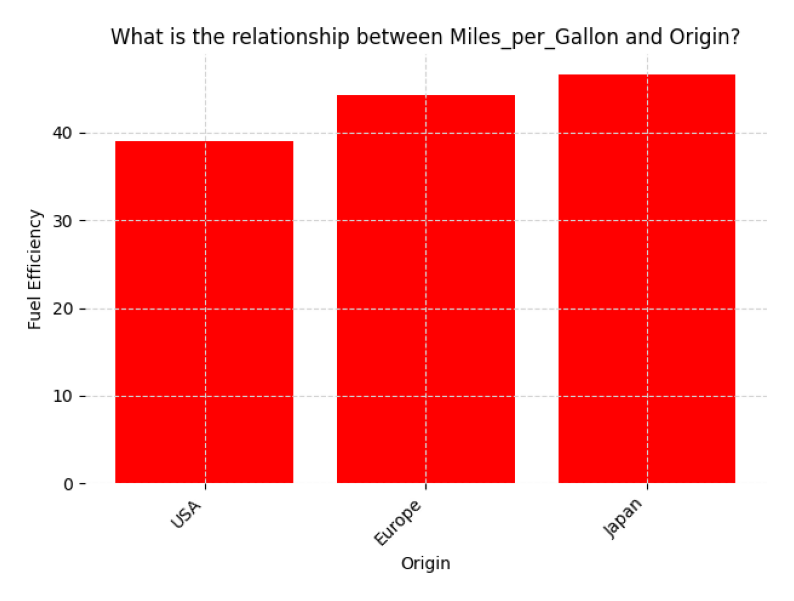

In [6]:
edited_charts = lida.execute_viz(code_specs=vis_specs, data=lida.data, summary=summary, library=library) 
plot_raster(edited_charts[0].raster)

## Visualization explanations and accessibility

In [7]:
explanations = lida.explain_viz(code=code,  library=library) 

In [8]:
print(explanations)

[[{'section': 'accessibility', 'code': 'None', 'explanation': 'The code generates a scatter plot using the matplotlib library. The plot shows the relationship between the Miles_per_Gallon and Weight_in_lbs variables in the input data. The color of each point in the plot represents the number of cylinders in the corresponding car. The goal of the chart is to visualize the relationship between the two variables and to see if there is any correlation between them. The main insights from the chart are the distribution of the data points and any patterns or trends that may be present.'}, {'section': 'transformation', 'code': 'None', 'explanation': "There is no data transformation in this code. The input data is assumed to be a pandas DataFrame with columns named 'Weight_in_lbs', 'Miles_per_Gallon', and 'Cylinders'."}, {'section': 'visualization', 'code': "plt.scatter(data['Weight_in_lbs'], data['Miles_per_Gallon'], c=data['Cylinders'], cmap='viridis')\nplt.xlabel('Weight_in_lbs')\nplt.ylabe

In [9]:
for row in explanations[0]:
    print(row["section"]," ** ", row["explanation"])
 

accessibility  **  The code generates a scatter plot using the matplotlib library. The plot shows the relationship between the Miles_per_Gallon and Weight_in_lbs variables in the input data. The color of each point in the plot represents the number of cylinders in the corresponding car. The goal of the chart is to visualize the relationship between the two variables and to see if there is any correlation between them. The main insights from the chart are the distribution of the data points and any patterns or trends that may be present.
transformation  **  There is no data transformation in this code. The input data is assumed to be a pandas DataFrame with columns named 'Weight_in_lbs', 'Miles_per_Gallon', and 'Cylinders'.
visualization  **  The visualization section of the code creates a scatter plot using the plt.scatter() function. The x-axis of the plot represents the 'Weight_in_lbs' variable, while the y-axis represents the 'Miles_per_Gallon' variable. The color of each point in t

## Visualization code self-evaluation and repair

In [10]:
evaluations = lida.evaluate_viz(code=code,  goal=goals[i], library=library)
evaluations = json.loads(evaluations[0])

In [12]:
for eval in evaluations:
    print(eval["dimension"], "Score" ,eval["score"], "/ 10")
    print("\t", eval["rationale"][:200])

bugs Score 10 / 10
	 The code does not contain any bugs, syntax errors, or typos. It should compile without any issues.
transformation Score 10 / 10
	 The data is appropriately transformed for the scatter plot. The dataset is not filtered, aggregated, or grouped, but the scatter plot is an appropriate visualization type for exploring the relationshi
compliance Score 10 / 10
	 The code meets the specified visualization goal of exploring the relationship between Miles_per_Gallon and Weight_in_lbs.
type Score 10 / 10
	 The scatter plot is an appropriate visualization type for exploring the relationship between two continuous variables.
encoding Score 10 / 10
	 The data is encoded appropriately for the scatter plot. The x-axis represents Weight_in_lbs, the y-axis represents Miles_per_Gallon, and the color represents the number of cylinders.
aesthetics Score 10 / 10
	 The aesthetics of the scatter plot are appropriate for the visualization type and the data. The x-axis and y-axis labels are